    Laboratory 2
    Scebec Mihai IS-211M


1. Analyse the dataset : the context, size, difficulties, detect the objectives.

In [157]:
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from multiprocessing import cpu_count
from sklearn import feature_selection
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, Input, Flatten, Reshape, concatenate, Dropout
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Embedding
from keras import optimizers
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [93]:
# context
newsgroups_train = fetch_20newsgroups(subset='train', random_state=42, shuffle=True)
pprint(list(newsgroups_train.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [94]:
# size
len(newsgroups_train.data)
len(newsgroups_train.filenames)
print(f"Number of files: {len(newsgroups_train.filenames)}")

print("\n".join(newsgroups_train.data[0].split("\n")[:3]))
print(newsgroups_train.target_names[newsgroups_train.target[0]])

print(newsgroups_train.target[:10])
for t in newsgroups_train.target[:10]:
    print(newsgroups_train.target_names[t])
print("====/====/====/====/")
for name in newsgroups_train.target_names:
    news = fetch_20newsgroups(subset='train', categories=[name]).data
    print(f"Category {name} has {len(news)} records")



Number of files: 11314
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
rec.autos
[ 7  4  4  1 14 16 13  3  2  4]
rec.autos
comp.sys.mac.hardware
comp.sys.mac.hardware
comp.graphics
sci.space
talk.politics.guns
sci.med
comp.sys.ibm.pc.hardware
comp.os.ms-windows.misc
comp.sys.mac.hardware
====/====/====/====/
Category alt.atheism has 480 records
Category comp.graphics has 584 records
Category comp.os.ms-windows.misc has 591 records
Category comp.sys.ibm.pc.hardware has 590 records
Category comp.sys.mac.hardware has 578 records
Category comp.windows.x has 593 records
Category misc.forsale has 585 records
Category rec.autos has 594 records
Category rec.motorcycles has 598 records
Category rec.sport.baseball has 597 records
Category rec.sport.hockey has 600 records
Category sci.crypt has 595 records
Category sci.electronics has 591 records
Category sci.med has 594 records
Category sci.space has 593 records
Category soc.religion.ch

Difficulties and objectives? In progress

1. Assign a fixed integer id to each word occurring in any document of the training
set (for instance by building a dictionary from words to integer indices).

Below I am trying to modify the data and to use bag of words.
I'll start with lowering the case of all text and ignoring/removing frequent words.

In [95]:
# print("\n".join(newsgroups_train.data[0].split("\n")[:3]))
common_words = ['the','at','there','some','my','of','be','use','her','than','and','this','an','would','first','a','have','each','make'
                ,'water','to','from','which','like','been','in','or','she','him','call','is','one','do','into','who','you','had','how'
                ,'time','oil','that','by','their','has','its','it','word','if','look','now','he','but','will','two','find','was','not'
                ,'up','more','long','for','what','other','write','down','on','all','about','go','day','are','were','out','see','did'
                ,'as','we','many','number','get','with','when','then','no','come','his','your','them','way','made']
data_for_groups = []
news_data = newsgroups_train["data"]

def filter_text_data(data):
    filtered_data = [re.sub('\n', ' ', new) for new in data]
    filtered_data = [re.sub('\t', ' ', new) for new in filtered_data]
    filtered_data = [re.sub('\r', ' ', new) for new in filtered_data]
    filtered_data = [re.sub('\a', ' ', new) for new in filtered_data]
    filtered_data = [re.sub(r'[^\w]', ' ', new) for new in filtered_data]
    for word in common_words:
        filtered_data = [new.replace(' '+word+' ', ' ') for new in filtered_data]
    filtered_data = [new.lower() for new in filtered_data]
    for d in filtered_data:
        d = " ".join([w for w in d.split() if w != ""])
    # filtered_data = [new.strip() for new in filtered_data]
    # didnt manage to make it work in time
    return filtered_data

# filtered_data = [re.sub(r'[^\w]', ' ', new) for new in news_data]
# for word in common_words:
#     filtered_data = [new.replace(word, ' ') for new in filtered_data]
# filtered_data = [new.lower() for new in filtered_data]
# filtered data should be valid
filtered_data = filter_text_data(news_data)

for name, data in zip(newsgroups_train.target_names, newsgroups_train.data):
    info_about_group = {}
    info_about_group['name'] = name
    info_about_group['word_dict'] = {}
    info_about_group['word_occurence'] = {}
    info_about_group['word_occurence_indexes_and_occurences'] = {}
    data = re.sub(r'[^\w]', ' ', data)
    data = data.lower()
    integer = 0
    

    reversed_word_occurence_dict = {}
    for word in data.split(' '):
        if word and len(word)>1:
            if word not in info_about_group['word_dict'] and word not in common_words:
                    info_about_group['word_dict'][word] = integer
                    integer += 1

    for word in info_about_group['word_dict']:
        info_about_group['word_occurence'][word] = 0

    for word in data.split(' '):
        if word and len(word)>1:
            if word in info_about_group['word_dict']:
                info_about_group['word_occurence'][word] += 1
    data_for_groups.append(info_about_group)

    for integer, occurence in zip(info_about_group['word_dict'].values(), info_about_group['word_occurence'].values()):
        info_about_group['word_occurence_indexes_and_occurences'][integer] = occurence

print(data_for_groups[4]['word_occurence_indexes_and_occurences'])




{0: 1, 1: 1, 2: 1, 3: 1, 4: 3, 5: 2, 6: 1, 7: 1, 8: 1, 9: 1, 10: 2, 11: 2, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 2, 24: 1, 25: 1, 26: 2, 27: 2, 28: 2, 29: 1, 30: 2, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 3, 45: 2, 46: 1, 47: 1, 48: 3, 49: 1, 50: 1, 51: 2, 52: 2, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 2, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 2, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 2, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1}


In [96]:
# I guess we are counting words now with some pre-built functions
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(filtered_data)
print(X_train_counts.shape)
print(count_vect.vocabulary_.get(u'algorithm'))

(11314, 130107)
27366


In [97]:
# as my friend suggested to try tfid tgransform as well, because words frequency can be better than just word count
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# this is an example with formatted data
tfidf_vectorizer = TfidfVectorizer()
vectors = tfidf_vectorizer.fit_transform(filtered_data)
# So, if we use already defined functions to vectorize, fit and predict, here it is
newsgroups_test = fetch_20newsgroups(subset='test', random_state=42, shuffle=True)
vectors_test = tfidf_vectorizer.transform(filter_text_data(newsgroups_test.data))
clf = MultinomialNB(alpha=.01)
clf.fit(vectors, newsgroups_train.target)
pred = clf.predict(vectors_test)
metrics.f1_score(newsgroups_test.target, pred, average='macro')

0.8299999321458893

In [98]:
# When the torture is done, let's stick to predefined functions
# this is an example with original data
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train.data)
# So, if we use already defined functions to vectorize, fit and predict, here it is
newsgroups_test = fetch_20newsgroups(subset='test', random_state=42, shuffle=True)
vectors_test = vectorizer.transform(newsgroups_test.data)
clf = MultinomialNB(alpha=.01)
clf.fit(vectors, newsgroups_train.target)
pred = clf.predict(vectors_test)
metrics.f1_score(newsgroups_test.target, pred, average='macro')
# overall, not worth the fuzz

0.8290659644474043

Trying different embedding techniques?

I won't even pretend that I had time to work and properly test all these, I googled as many examples as I could and hopefully made them work

In the lab doc there were mentioned word2vec, FastText, document2vec, BERT, Glove.

In [159]:
fs = feature_selection.SelectPercentile(feature_selection.chi2, percentile=40)
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000

def text_CNN(embedding_layer):
    sequence_input = Input(shape=(MAX_LEN,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
   
    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    
    embedded_sequences = Reshape((MAX_LEN, EMBEDDING_DIM, 1))(embedded_sequences)
    x = Conv2D(100, (5, EMBEDDING_DIM), activation='relu')(embedded_sequences)
    x = MaxPooling2D((MAX_LEN - 5 + 1, 1))(x)

    y = Conv2D(100, (4, EMBEDDING_DIM), activation='relu')(embedded_sequences)
    y = MaxPooling2D((MAX_LEN - 4 + 1, 1))(y)

    z = Conv2D(100, (3, EMBEDDING_DIM), activation='relu')(embedded_sequences)
    z = MaxPooling2D((MAX_LEN - 3 + 1, 1))(z)

    alpha = concatenate([x,y,z])
    alpha = Flatten()(alpha)
    alpha = Dropout(0.5)(alpha)
    preds = Dense(len(news_groups_train.target_names), activation='softmax')(alpha)
    model = Model(sequence_input, preds)
    adadelta = tf.optimizers.Adadelta()
        
    model.compile(loss='categorical_crossentropy',
                  optimizer=adadelta,
                  metrics=['acc'])
    return model

def show_history(history):
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def show_performance_with_gscv(name, model, x_train, y_train, params):
    results = {}
    results['model_name'] = name
    gscv = GridSearchCV(model, params, cv=3, n_jobs=cpu_count()-1, return_train_score=True)
#     x_train_fs = fs.fit_transform(x_train, y_train)
    
    gscv.fit(x_train, y_train)
    
    results['params'] = gscv.best_params_
    results['train_time'] = np.mean(gscv.cv_results_['mean_fit_time'])
    results['val_time'] = np.mean(gscv.cv_results_['mean_score_time'])
    results['train_score'] = gscv.cv_results_['mean_train_score'][gscv.best_index_]
    
    # it is get fro train data set, could be taken as a val result
    results['val_score'] = gscv.cv_results_['mean_test_score'][gscv.best_index_]
    
    results['best_model'] = gscv.best_estimator_
    
    return results

def show_distributation(data):
    dict = {}
    for index, name in enumerate(news_groups_train.target_names):
        dict.setdefault(name, np.sum(data==index))
    print(dict)
    print(dict.keys())
    print(dict.values())
    
    index = np.arange(len(news_groups_train.target_names))
    plt.figure(figsize=(10,5))
    plt.bar(index, dict.values())
    plt.xticks(index, dict.keys(), rotation=90)
    plt.title("category distributation")
    plt.xlabel("data count")
    plt.ylabel("data category")
    plt.show()

def show_performance(model, x_train, y_train, x_val, y_val):    
    results = {}
    results['model_name'] = model.__class__.__name__
    t0 = time()
    model.fit(x_train, y_train)
    results['train_time'] = time() - t0
    t1 = time()
    predicts = model.predict(x_train)
    results['val_time'] = time() - t1
    train_score = model.score(x_train, y_train)
    val_score = model.score(x_val, y_val)
    results['train_score'] = train_score
    results['val_score'] = val_score
    print(results)


def show_words(data):
    count = []
    for f in data:
        count.append(len(f.split()))
    plt.figure(figsize=(10,5))
    plt.hist(count, bins=20)
    plt.title("words distributation")
    plt.xlabel("words count")
    plt.ylabel("words weight")
    plt.show()
    
def show_chars(data):
    count = []
    for f in data:
        count.append(len(f))
    plt.figure(figsize=(10,5))
    plt.hist(count, bins=20)
    plt.title("chars distributation")
    plt.xlabel("chars count")
    plt.ylabel("chars count")
    plt.show()

def autolabel(ax, rects, xpos='center'):
        xpos = xpos.lower()  # normalize the case of the parameter
        ha = {'center': 'center', 'right': 'left', 'left': 'right'}
        offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                    '{}'.format(height), ha=ha[xpos], va='bottom')
            
def show_metrics(rs_lr, rs_svc, rs_nb):
    train_time = (rs_lr['train_time'], rs_svc['train_time'], rs_nb['train_time'])
    val_time = (rs_lr['val_time'], rs_svc['val_time'], rs_nb['val_time'])
    
    train_score = (rs_lr['train_score'], rs_svc['train_score'], rs_nb['train_score'])
    val_score = (rs_lr['val_score'], rs_svc['val_score'], rs_nb['val_score'])

    ind = np.arange(len(train_time))  # the x locations for the groups
    width = 0.35  # the width of the bars

    fig, ax0 = plt.subplots(1, 1, figsize = (16,5))
    
    rects1 = ax0.bar(ind - width/2, train_time, width,
                    color='SkyBlue', label='train time')
    rects2 = ax0.bar(ind + width/2, val_time, width,
                    color='IndianRed', label='val time')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax0.set_ylabel('time')
    ax0.set_title('time by train and val')
    ax0.set_xticks(ind)
    ax0.set_xticklabels(('LogisticRegression', 'SVC', 'NaiveBayes'))
    ax0.legend()
    autolabel(ax0, rects1, "left")
    autolabel(ax0, rects2, "right")
    plt.show()
    
    fig, ax1 = plt.subplots(1, 1, figsize = (16,5))
    
    rects3 = ax1.bar(ind - width/2, train_score, width,
                    color='SkyBlue', label='train score')
    rects4 = ax1.bar(ind + width/2, val_score, width,
                    color='IndianRed', label='val score')
    ax1.set_ylabel('Scores')
    ax1.set_title('Scores by train and val')
    ax1.set_xticks(ind)
    ax1.set_xticklabels(('LogisticRegression', 'SVC', 'NaiveBayes'))
    ax1.legend()
    autolabel(ax1, rects3, "left")
    autolabel(ax1, rects4, "right")
    plt.show()

In [106]:
# let's start all over again then
news_groups_train = fetch_20newsgroups(subset='train', shuffle=True, download_if_missing=False)
news_groups_test = fetch_20newsgroups(subset='test', shuffle=True, download_if_missing=False)
filtered_train = filter_text_data(news_groups_train.data)
filtered_test = filter_text_data(news_groups_test.data)
x_train, y_train = filtered_train, news_groups_train.target
x_sp_train, x_sp_val, y_sp_train, y_sp_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)
x_test, y_test = filtered_train, news_groups_test.target

In [107]:
print("count for data in 20 news groups", len(x_sp_train), len(x_sp_val), len(x_test))
print("count for train and validation data in 20 news groups", len(x_sp_train) + len(x_sp_val), " and for test data", len(x_test))
print("count for train data in 20 news groups", len(x_sp_train))
print("count for validation data in 20 news groups", len(x_sp_val))
print("count for test data in 20 news groups", len(x_test))

count for data in 20 news groups 9051 2263 11314
count for train and validation data in 20 news groups 11314  and for test data 11314
count for train data in 20 news groups 9051
count for validation data in 20 news groups 2263
count for test data in 20 news groups 11314


In [108]:
print(x_sp_train[10])

from  djf cck coventry ac uk  marvin batty  subject  re  moonbase race nntp posting host  cc_sysk organization  starfleet  coventry  uk lines  22  in article  1r46o9inn14j mojo eng umd edu  sysmgr king eng umd edu writes   in article  c5teik 7z9 zoo toronto edu   henry zoo toronto edu  henry spencer  writes      apollo done hard  big hurry  very limited   technology base    government contracts   just doing privately    rather government project  cuts costs factor several     so much cost private venture  assuming could talk  u s  government leasing couple pads florida     why ground launch pad  it entirely posible launch altitude  this shuttle originally intended  it might seriously cheaper    also  bio engineered co2 absorbing plants instead lox bottles  stick  em lunar cave put airlock door                                                                                                        marvin batty   djf uk ac cov cck  and they shall those things  sort rafia base  fathers put 

{'alt.atheism': 392, 'comp.graphics': 456, 'comp.os.ms-windows.misc': 478, 'comp.sys.ibm.pc.hardware': 462, 'comp.sys.mac.hardware': 458, 'comp.windows.x': 473, 'misc.forsale': 480, 'rec.autos': 477, 'rec.motorcycles': 470, 'rec.sport.baseball': 478, 'rec.sport.hockey': 485, 'sci.crypt': 465, 'sci.electronics': 469, 'sci.med': 495, 'sci.space': 471, 'soc.religion.christian': 472, 'talk.politics.guns': 431, 'talk.politics.mideast': 452, 'talk.politics.misc': 385, 'talk.religion.misc': 302}
dict_keys(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc'])
dict_values([392, 456, 478, 462, 458, 473, 480, 477, 470, 478, 485, 465, 469, 495, 471, 472, 431, 452

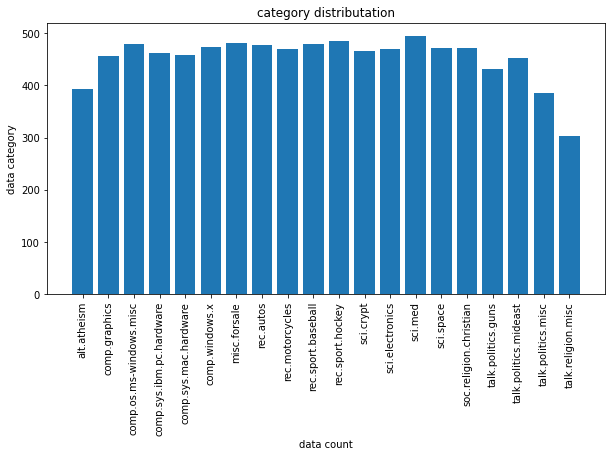

In [114]:
show_distributation(y_sp_train)

{'alt.atheism': 88, 'comp.graphics': 128, 'comp.os.ms-windows.misc': 113, 'comp.sys.ibm.pc.hardware': 128, 'comp.sys.mac.hardware': 120, 'comp.windows.x': 120, 'misc.forsale': 105, 'rec.autos': 117, 'rec.motorcycles': 128, 'rec.sport.baseball': 119, 'rec.sport.hockey': 115, 'sci.crypt': 130, 'sci.electronics': 122, 'sci.med': 99, 'sci.space': 122, 'soc.religion.christian': 127, 'talk.politics.guns': 115, 'talk.politics.mideast': 112, 'talk.politics.misc': 80, 'talk.religion.misc': 75}
dict_keys(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc'])
dict_values([88, 128, 113, 128, 120, 120, 105, 117, 128, 119, 115, 130, 122, 99, 122, 127, 115, 112, 80, 

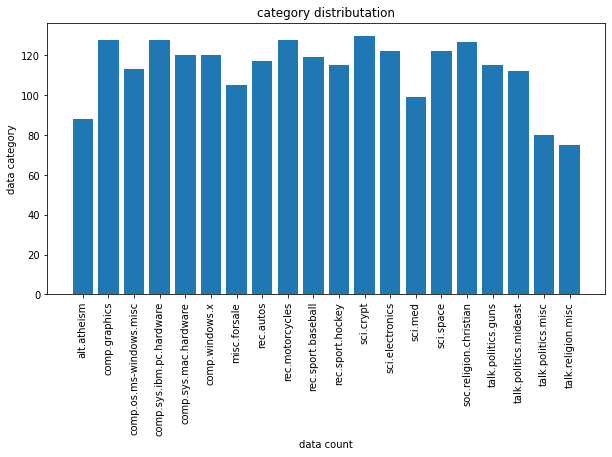

In [115]:
show_distributation(y_sp_val)

{'alt.atheism': 319, 'comp.graphics': 389, 'comp.os.ms-windows.misc': 394, 'comp.sys.ibm.pc.hardware': 392, 'comp.sys.mac.hardware': 385, 'comp.windows.x': 395, 'misc.forsale': 390, 'rec.autos': 396, 'rec.motorcycles': 398, 'rec.sport.baseball': 397, 'rec.sport.hockey': 399, 'sci.crypt': 396, 'sci.electronics': 393, 'sci.med': 396, 'sci.space': 394, 'soc.religion.christian': 398, 'talk.politics.guns': 364, 'talk.politics.mideast': 376, 'talk.politics.misc': 310, 'talk.religion.misc': 251}
dict_keys(['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc'])
dict_values([319, 389, 394, 392, 385, 395, 390, 396, 398, 397, 399, 396, 393, 396, 394, 398, 364, 376

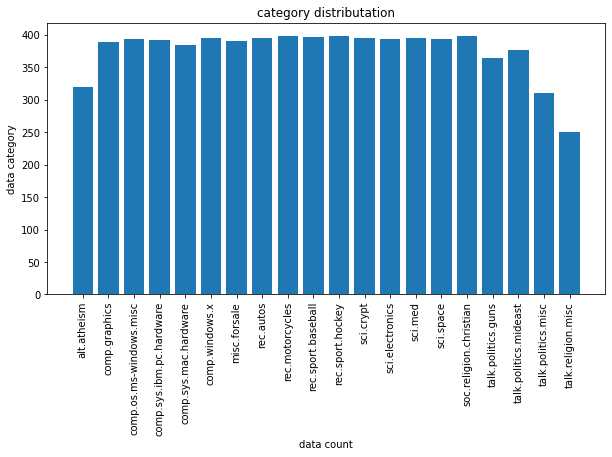

In [116]:
show_distributation(y_test)

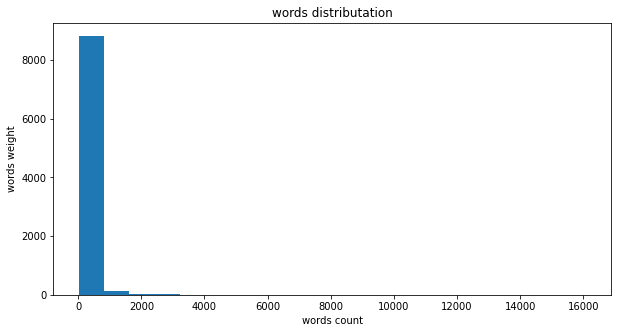

In [118]:
show_words(x_sp_train)

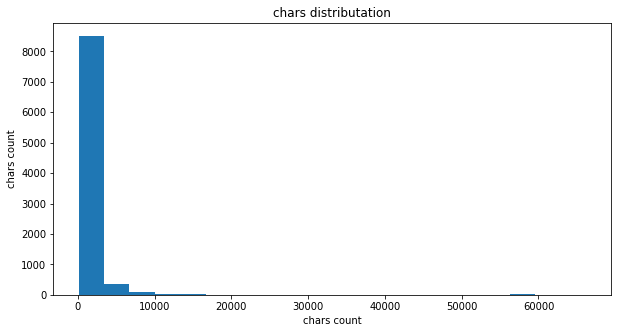

In [119]:
show_chars(x_sp_train)

In [124]:
vectorizer = CountVectorizer(max_df=0.97, min_df=3,
                                max_features=None,
                                stop_words='english')
vec_x_train = vectorizer.fit_transform(x_sp_train)
print(vec_x_train)

  (0, 3690)	5
  (0, 11963)	1
  (0, 31540)	1
  (0, 27447)	2
  (0, 17044)	2
  (0, 29875)	1
  (0, 4835)	3
  (0, 9808)	2
  (0, 843)	1
  (0, 22261)	1
  (0, 3992)	1
  (0, 8554)	1
  (0, 18156)	1
  (0, 15031)	2
  (0, 31245)	1
  (0, 2317)	1
  (0, 1364)	1
  (0, 1229)	1
  (0, 21345)	2
  (0, 27183)	1
  (0, 30910)	2
  (0, 11617)	4
  (0, 29670)	1
  (0, 22295)	1
  (0, 21824)	1
  :	:
  (9050, 4638)	1
  (9050, 10294)	1
  (9050, 19577)	1
  (9050, 30051)	1
  (9050, 10748)	1
  (9050, 19840)	1
  (9050, 6631)	1
  (9050, 27999)	1
  (9050, 7654)	1
  (9050, 21566)	1
  (9050, 5957)	1
  (9050, 32212)	1
  (9050, 3705)	1
  (9050, 22290)	1
  (9050, 19412)	3
  (9050, 32680)	2
  (9050, 8257)	1
  (9050, 23391)	1
  (9050, 1058)	1
  (9050, 28860)	1
  (9050, 30371)	1
  (9050, 19568)	1
  (9050, 18984)	1
  (9050, 3639)	1
  (9050, 29399)	1


In [126]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.97, min_df=2,
                                max_features=None,
                                stop_words='english')

tfidf_x_sp_train = tfidf_vectorizer.fit_transform(x_sp_train)
tfidf_x_sp_val = tfidf_vectorizer.transform(x_sp_val)

tfidf_x_train = tfidf_vectorizer.transform(x_train)
tfidf_x_test = tfidf_vectorizer.transform(x_test)

print(tfidf_x_sp_train.shape)
print(tfidf_x_sp_val.shape)
print(tfidf_x_train.shape)
print(tfidf_x_test.shape)

print(tfidf_x_sp_train)

(9051, 49254)
(2263, 49254)
(11314, 49254)
(11314, 49254)
  (0, 9116)	0.056491052833452474
  (0, 34277)	0.04662122636448474
  (0, 25839)	0.029071277436323498
  (0, 13630)	0.04171413543167023
  (0, 29653)	0.03719398081328389
  (0, 47241)	0.04177266299213154
  (0, 48009)	0.03232820196590292
  (0, 42799)	0.02561667902683956
  (0, 19420)	0.05613332709226455
  (0, 40026)	0.04463461887716532
  (0, 17118)	0.04231949622189823
  (0, 9722)	0.030022167402050087
  (0, 10778)	0.04446868507902601
  (0, 4910)	0.04515399289011522
  (0, 711)	0.028188317553190602
  (0, 7725)	0.047409724101704874
  (0, 48744)	0.06570650973827732
  (0, 27696)	0.06570650973827732
  (0, 23140)	0.054550300194369725
  (0, 32647)	0.04640943771810875
  (0, 10028)	0.04008334872539442
  (0, 38364)	0.05905381053775964
  (0, 38113)	0.04941528920460408
  (0, 44336)	0.06368405584829383
  (0, 20580)	0.04662122636448474
  :	:
  (9050, 29458)	0.09724489890799684
  (9050, 34208)	0.09556894303914447
  (9050, 14019)	0.08644382769668345
  (

In [132]:
# make word2vec model
model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [133]:
lr = LogisticRegression(C=1.0, penalty='l2')
show_performance(lr, tfidf_x_sp_train, y_sp_train, tfidf_x_sp_val, y_sp_val)

{'model_name': 'LogisticRegression', 'train_time': 13.854101181030273, 'val_time': 0.01900005340576172, 'train_score': 0.9791183294663574, 'val_score': 0.8992487847989394}


In [134]:
svc = SVC(kernel='linear', C=0.5, gamma=0.9, random_state=0)
show_performance(svc, tfidf_x_sp_train, y_sp_train, tfidf_x_sp_val, y_sp_val)

{'model_name': 'SVC', 'train_time': 68.07835531234741, 'val_time': 55.86075687408447, 'train_score': 0.9824328803447133, 'val_score': 0.9032258064516129}


In [138]:
gnb = MultinomialNB(alpha=0.5)
show_performance(gnb, tfidf_x_sp_train, y_sp_train, tfidf_x_sp_val, y_sp_val)

{'model_name': 'MultinomialNB', 'train_time': 0.04699373245239258, 'val_time': 0.021004676818847656, 'train_score': 0.9712738923875814, 'val_score': 0.891736632788334}


In [139]:
params = {'C': [0.01, 1, 3]}
rs_lr = show_performance_with_gscv('LogisticRegression', LogisticRegression(penalty='l2'), tfidf_x_train, y_train, params)
print(rs_lr)

{'model_name': 'LogisticRegression', 'params': {'C': 3}, 'train_time': 45.50942958725824, 'val_time': 0.04247893227471245, 'train_score': 0.995359719569556, 'val_score': 0.9040129370025326, 'best_model': LogisticRegression(C=3)}


c:\Users\otaku\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [141]:
params = {'C': [0.1, 1, 3], 'gamma':[0.5, 0.9]}
rs_svc = show_performance_with_gscv('SVC', SVC(kernel='linear'), tfidf_x_train, y_train, params)
print(rs_svc)

{'model_name': 'SVC', 'params': {'C': 3, 'gamma': 0.5}, 'train_time': 111.33690526750352, 'val_time': 34.86272047625648, 'train_score': 0.9992487223052665, 'val_score': 0.9067533114195242, 'best_model': SVC(C=3, gamma=0.5, kernel='linear')}


In [146]:
params = {'alpha': [0.0001, 0.01, 0.5, 0.95]}
rs_nb = show_performance_with_gscv('NaiveBayes', MultinomialNB(), tfidf_x_train, y_train, params)
print(rs_nb)

{'model_name': 'NaiveBayes', 'params': {'alpha': 0.01}, 'train_time': 0.2047161062558492, 'val_time': 0.05462815364201863, 'train_score': 0.9966413429851532, 'val_score': 0.9056920458347125, 'best_model': MultinomialNB(alpha=0.01)}


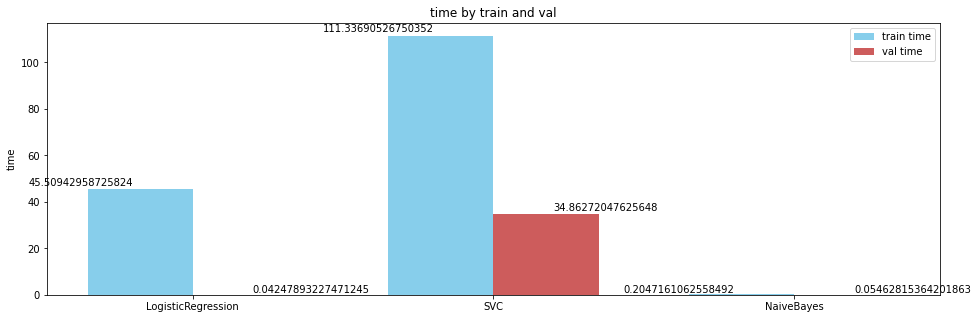

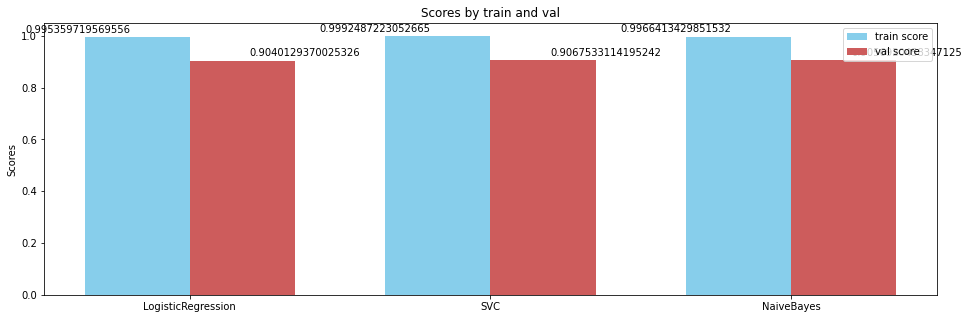

In [148]:
show_metrics(rs_lr, rs_svc, rs_nb)

In [149]:
words_count = []
for i in x_train:
    words_count.append(len(text_to_word_sequence(i, split=' ')))
print(np.max(words_count))
print(np.min(words_count))
# 18~ 16333
NUM_WORDS = 20000
MAX_LEN= 1000
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(x_sp_train)
word_index = tokenizer.word_index
x_sp_train_dl = pad_sequences(tokenizer.texts_to_sequences(x_sp_train), maxlen=MAX_LEN)
y_sp_train_dl = to_categorical(np.asarray(y_sp_train), num_classes=20)

x_sp_val_dl = pad_sequences(tokenizer.texts_to_sequences(x_sp_val), maxlen=MAX_LEN)
y_sp_val_dl = to_categorical(np.asarray(y_sp_val), num_classes=20)

x_test_dl = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen=MAX_LEN)
y_test_dl = to_categorical(np.asarray(y_test), num_classes=20)

16161
16


In [160]:
# finally using word2vec
min_num_words = min(NUM_WORDS, len(word_index))
embedding_matrix = np.zeros((min_num_words+1, EMBEDDING_DIM))


for word, index in word_index.items():
    for word in word:
        if word in model.wv:
            vec += _model.wv[word]
            embedding_matrix[index] = model[word]

print('embedding matrix shape: {}'.format(embedding_matrix.shape))   
embedding_layer = Embedding(min_num_words+1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_LEN, 
                            trainable=False)
text_cnn = text_CNN(embedding_layer)
text_cnn.summary()

embedding matrix shape: (20001, 100)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1000, 100)    2000100     ['input_2[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 1000, 100, 1  0           ['embedding_1[0][0]']            
                                )                                                                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 996, 1, 100)  50

In [169]:
early_stopping = EarlyStopping(monitor='val_acc', patience=2, mode='max')

history = text_cnn.fit(x_sp_train_dl, y_sp_train_dl, validation_data=(x_sp_val_dl, y_sp_val_dl), epochs=60, batch_size=50,callbacks=[early_stopping])

Epoch 1/60
182/182 [==============================] - 32s 173ms/step - loss: 2.9957 - acc: 0.0547 - val_loss: 2.9957 - val_acc: 0.0437
Epoch 2/60
182/182 [==============================] - 33s 183ms/step - loss: 2.9957 - acc: 0.0547 - val_loss: 2.9957 - val_acc: 0.0437
Epoch 3/60
182/182 [==============================] - 33s 184ms/step - loss: 2.9957 - acc: 0.0547 - val_loss: 2.9957 - val_acc: 0.0437


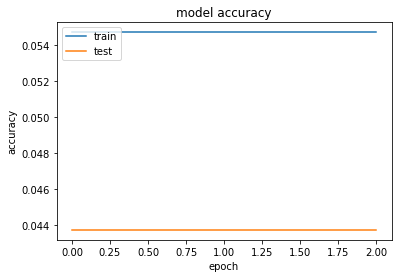

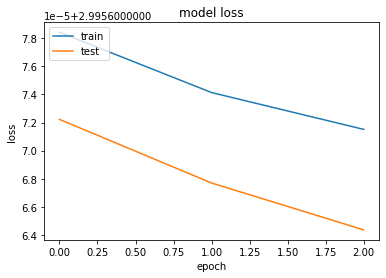

In [171]:
show_history(history.history)

As you can see there cannot be done a qualitative work in such short time, and the results are corresponding to that fact.

I stopped further analysis as I realized that even to finish word2vec using code & explanation from kaggle(!) I would need a couple days.
And I assume this is fair for every other approach. Asking to do this in a week from people that most probably work 8 hours a day is cruel to say the least.

Sorry. I don't have time and resources to properly work with all of this. 
As a conclusion this happened to be the work that I physically and mentally cannot do.